In [4]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
from src.utils.Contact_Matrix import matrix_scaling
from src.models.consolidated_dynamics import sim_SIRV_trajectory, sim_SIRT_trajectory, sim_maskSIR_trajectory
import jax
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional, Literal


def extract_distributions_and_matrices(
    file_path: str,
    apply_sinkhorn: bool = True,
    symmetrize: bool = True,
    n_bins: int = 5,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Dict[str, np.ndarray]:
    """
    Extract behavior distributions and contact matrices from survey data.
    
    Args:
        file_path: Path to the CSV file with survey data
        apply_sinkhorn: Whether to apply Sinkhorn normalization to contact matrices
        symmetrize: Whether to symmetrize contact matrices
        n_bins: Number of behavior bins (default: 5)
        max_iters: Maximum iterations for Sinkhorn normalization
        threshold: Convergence threshold for Sinkhorn normalization
        
    Returns:
        Dictionary containing:
        - DISTR_M: Mask-wearing behavior distribution
        - DISTR_T: Testing behavior distribution
        - DISTR_V: Vaccination behavior distribution
        - CM_M: Mask-wearing contact matrix
        - CM_T: Testing contact matrix
        - CM_V: Vaccination contact matrix
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Define behavior types and their corresponding keys in the result
    behavior_types = ["masks", "testing", "vacc"]
    result_keys = {
        "masks": {"dist": "DISTR_M", "cm": "CM_M"},
        "testing": {"dist": "DISTR_T", "cm": "CM_T"},
        "vacc": {"dist": "DISTR_V", "cm": "CM_V"}
    }
    
    # Initialize result dictionary
    result = {}
    
    for behavior_type in behavior_types:
        # Clean data
        df_clean = df.dropna(subset=[f'{behavior_type}_self'])
        
        # Get self-reported behavior and calculate behavior distribution
        self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
        behavior_counts = np.zeros(n_bins)
        for i in range(n_bins):
            behavior_counts[i] = np.sum(self_behavior == i+1)
        
        # Normalize to get population distribution
        behavior_distribution = behavior_counts / np.sum(behavior_counts)
        
        # Store behavior distribution in result
        result[result_keys[behavior_type]["dist"]] = np.array(behavior_distribution)
        
        # Initialize contact matrix
        contact_matrix = np.zeros((n_bins, n_bins))
        
        # Get columns for contact data based on behavior type
        if behavior_type == "vacc":
            cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
        else:
            cols = [
                f'{behavior_type}_others_never', 
                f'{behavior_type}_others_sometimes',
                f'{behavior_type}_others_half',
                f'{behavior_type}_others_often',
                f'{behavior_type}_others_always'
            ]
        
        # Fill contact matrix
        for i, row in df_clean.iterrows():
            self_idx = int(row[f'{behavior_type}_self']) - 1
            for j, col in enumerate(cols):
                if pd.notna(row[col]):
                    contact_matrix[self_idx, j] += row[col]
        
        # Normalize by group counts
        normalized_matrix = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                normalized_matrix[i, :] = contact_matrix[i, :] / group_count
        
        # Symmetrize if requested
        if symmetrize:
            normalized_matrix = 0.5 * (normalized_matrix + normalized_matrix.T)
        
        # Apply Sinkhorn normalization if requested
        if apply_sinkhorn:
            # Convert to JAX array for Sinkhorn normalization
            jax_matrix = jnp.array(normalized_matrix)
            sinkhorn_matrix, _, _ = matrix_scaling(
                jax_matrix, 
                max_iters=max_iters, 
                threshold=threshold
            )
            # Convert back to numpy and scale
            final_matrix = np.array(sinkhorn_matrix) * (n_bins**2)
        else:
            final_matrix = normalized_matrix * (n_bins**2)
        
        # Store contact matrix in result
        result[result_keys[behavior_type]["cm"]] = final_matrix
    
    return result

In [2]:
def find_equivalent_intensity(
    model_type: str,
    target_r0: float,
    N_COMPARTMENTS: int = 100,
    tolerance: float = 1e-4,
    max_iterations: int = 50,
    initial_range: Tuple[float, float] = (0.01, 10.0)
) -> float:
    """
    Find a disease intensity value that produces the target R0 for a homogeneous population.
    
    Args:
        model_type: Type of model ("mask", "test", or "vaccine")
        target_r0: The R0 value to match
        N_COMPARTMENTS: Number of compartments for the simulation
        tolerance: Acceptable error in R0 matching
        max_iterations: Maximum number of bisection iterations
        initial_range: Initial range to search for the intensity value
        
    Returns:
        Disease intensity value that produces the target R0
    """
    # Set up base parameters for consensus population
    beta_params = (1000.0, 1000.0)  # Very high alpha & beta = homogeneous population
    base_params = {
        'recovery_rate': 0.1,  # Default recovery rate
        'dT': 0.25,
        'homophilic_tendency': 0,  # No homophily
        'beta_params': beta_params,
        'SPB_exponent': 1.0
    }
    
    # Model-specific parameters
    if model_type == "mask":
        simulation_fn = sim_maskSIR_final
        param_name = 'beta_M'
        base_params['mu_max'] = 0.0  # No mask wearing in homogeneous population
    elif model_type == "test":
        simulation_fn = sim_SIRT_final
        param_name = 'susceptibility_rate'
        base_params['testing_rates'] = (0.0, 0.0)  # No testing in homogeneous population
    elif model_type == "vaccine":
        simulation_fn = sim_SIRV_final
        param_name = 'susceptibility_rate'
        base_params['vaccination_rates'] = (0.0, 0.0)  # No vaccination in homogeneous population
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    # Bisection search
    lower_bound, upper_bound = initial_range
    
    for _ in range(max_iterations):
        # Try middle value
        mid_point = (lower_bound + upper_bound) / 2
        
        # Set the intensity parameter
        current_params = dict(base_params)
        current_params[param_name] = mid_point
        
        # Run simulation to get R0
        _, current_r0, _ = simulation_fn(
            beta_params=beta_params,
            params=current_params,
            n_steps=1,  # We only need R0, not running the simulation
            N_COMPARTMENTS=N_COMPARTMENTS
        )
        
        # Check if we're close enough
        if abs(current_r0 - target_r0) < tolerance:
            return mid_point
        
        # Adjust bounds based on result
        if current_r0 < target_r0:
            lower_bound = mid_point
        else:
            upper_bound = mid_point
    
    # Return best estimate if max iterations reached
    return (lower_bound + upper_bound) / 2

def compare_r0_trajectories(
    model_type: str,
    behavior_distribution: jnp.ndarray,
    contact_matrix: jnp.ndarray,
    custom_populations: jnp.ndarray,
    n_steps: int = 400,
    dT: float = 0.25,
    recovery_rate: float = 0.1,
    initial_infected_prop: float = 1e-4
):
    """
    Compare epidemic trajectories for heterogeneous vs. homogeneous populations 
    with matching R0 values.
    
    Args:
        model_type: Type of model ("mask", "test", or "vaccine")
        behavior_distribution: Real behavior distribution data
        contact_matrix: Real contact matrix data
        custom_populations: Real population distribution data
        n_steps: Number of simulation steps
        dT: Time step size
        recovery_rate: Recovery rate
        initial_infected_prop: Initial infected proportion
        
    Returns:
        Dictionary with heterogeneous and homogeneous trajectories and R0 values
    """
    # Base parameters
    base_params = {
        'recovery_rate': recovery_rate,
        'dT': dT,
        'homophilic_tendency': 0,  # Not used when providing contact matrix
        'SPB_exponent': 1.0
    }
    
    # Set up for heterogeneous simulation
    if model_type == "mask":
        hetero_params = dict(base_params)
        hetero_params['beta_M'] = 0.6  # Default susceptibility
        sim_traj_fn = sim_maskSIR_trajectory
        sim_final_fn = sim_maskSIR_final
    elif model_type == "test":
        hetero_params = dict(base_params)
        hetero_params['susceptibility_rate'] = 0.6  # Default susceptibility
        hetero_params['testing_rates'] = (0.0, 0.3)  # Default testing range
        sim_traj_fn = sim_SIRT_trajectory
        sim_final_fn = sim_SIRT_final
    elif model_type == "vaccine":
        hetero_params = dict(base_params)
        hetero_params['susceptibility_rate'] = 0.6  # Default susceptibility
        hetero_params['vaccination_rates'] = (0.0, 0.05)  # Default vaccination range
        sim_traj_fn = sim_SIRV_trajectory
        sim_final_fn = sim_SIRV_final
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    # Run heterogeneous simulation (with real data) to get R0
    _, hetero_r0, _ = sim_final_fn(
        beta_params=(1.0, 1.0),  # Doesn't matter when providing custom data
        params=hetero_params,
        n_steps=1,  # Just to get R0
        behavior_distribution=behavior_distribution,
        custom_contact_matrix=contact_matrix,
        custom_populations=custom_populations
    )
    
    # Find equivalent intensity for homogeneous population
    if model_type == "mask":
        param_name = 'beta_M'
    else:
        param_name = 'susceptibility_rate'
    
    equiv_intensity = find_equivalent_intensity(
        model_type=model_type,
        target_r0=hetero_r0
    )
    
    # Set up homogeneous simulation parameters
    homo_params = dict(base_params)
    homo_params[param_name] = equiv_intensity
    
    if model_type == "test":
        homo_params['testing_rates'] = (0.0, 0.0)  # No testing
    elif model_type == "vaccine":
        homo_params['vaccination_rates'] = (0.0, 0.0)  # No vaccination
    elif model_type == "mask":
        homo_params['mu_max'] = 0.0  # No mask wearing
    
    # Homogeneous population parameters
    homo_beta_params = (1000.0, 1000.0)  # Very high alpha & beta for homogeneity
    
    # Run both simulations for full trajectories
    hetero_trajectory, _, _ = sim_traj_fn(
        beta_params=(1.0, 1.0),  # Not used with custom data
        params=hetero_params,
        n_steps=n_steps,
        behavior_distribution=behavior_distribution,
        custom_contact_matrix=contact_matrix,
        custom_populations=custom_populations
    )
    
    homo_trajectory, homo_r0, _ = sim_traj_fn(
        beta_params=homo_beta_params,
        params=homo_params,
        n_steps=n_steps,
        N_COMPARTMENTS=100  # Default compartments for homogeneous population
    )
    
    # Prepare results
    result = {
        'heterogeneous': {
            'trajectory': hetero_trajectory,
            'r0': hetero_r0,
            'populations': custom_populations
        },
        'homogeneous': {
            'trajectory': homo_trajectory,
            'r0': homo_r0,
            'intensity': equiv_intensity
        },
        'model_type': model_type,
        'time_steps': n_steps,
        'dT': dT
    }
    
    return result

def plot_r0_comparison(comparison_results, plot_title=None):
    """
    Plot epidemic trajectories for heterogeneous vs. homogeneous populations with matching R0.
    
    Args:
        comparison_results: Results from compare_r0_trajectories
        plot_title: Optional custom title for the plot
    """
    model_type = comparison_results['model_type']
    hetero_traj = comparison_results['heterogeneous']['trajectory']
    homo_traj = comparison_results['homogeneous']['trajectory']
    hetero_r0 = comparison_results['heterogeneous']['r0']
    homo_r0 = comparison_results['homogeneous']['r0']
    
    n_steps = comparison_results['time_steps']
    dT = comparison_results['dT']
    time_points = np.arange(0, n_steps + 1) * dT
    
    # Convert to numpy for plotting
    hetero_S = np.asarray(hetero_traj[0])
    hetero_I = np.asarray(hetero_traj[1])
    hetero_R = np.asarray(hetero_traj[2])
    
    homo_S = np.asarray(homo_traj[0])
    homo_I = np.asarray(homo_traj[1])
    homo_R = np.asarray(homo_traj[2])
    
    # Total populations over time
    hetero_pop = comparison_results['heterogeneous']['populations']
    hetero_total_S = np.sum(hetero_S, axis=1)
    hetero_total_I = np.sum(hetero_I, axis=1)
    hetero_total_R = np.sum(hetero_R, axis=1)
    
    homo_total_S = np.sum(homo_S, axis=1)
    homo_total_I = np.sum(homo_I, axis=1)
    homo_total_R = np.sum(homo_R, axis=1)
    
    # Plot setup
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot total population trajectories
    ax = axes[0]
    ax.plot(time_points, hetero_total_S, 'b-', label='Heterogeneous S')
    ax.plot(time_points, hetero_total_I, 'r-', label='Heterogeneous I')
    ax.plot(time_points, hetero_total_R, 'g-', label='Heterogeneous R')
    
    ax.plot(time_points, homo_total_S, 'b--', label='Homogeneous S')
    ax.plot(time_points, homo_total_I, 'r--', label='Homogeneous I')
    ax.plot(time_points, homo_total_R, 'g--', label='Homogeneous R')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Population Dynamics: Heterogeneous vs. Homogeneous\nBoth with R0 ≈ {hetero_r0:.2f}')
    ax.legend()
    ax.grid(True)
    
    # Plot infected population
    ax = axes[1]
    ax.plot(time_points, hetero_total_I, 'r-', linewidth=2, label='Heterogeneous')
    ax.plot(time_points, homo_total_I, 'b--', linewidth=2, label='Homogeneous')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Infected Population')
    ax.set_title('Infected Population: Heterogeneous vs. Homogeneous')
    ax.legend()
    ax.grid(True)
    
    # Add model-specific information
    if model_type == "mask":
        model_desc = "Mask-Wearing (SIRM)"
    elif model_type == "test":
        model_desc = "Testing-Based (SIRT)"
    elif model_type == "vaccine":
        model_desc = "Vaccination (SIRV)"
    
    if plot_title:
        fig.suptitle(plot_title, fontsize=16)
    else:
        fig.suptitle(f'Comparing {model_desc} Model Dynamics with Identical R0 Values\nR0 = {hetero_r0:.2f}', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

def process_survey_data(
    survey_data_path: str = 'data_homophily.csv',
    behavior_type: str = 'masks',
    model_type: str = 'mask',
    n_bins: int = 5
):
    """
    Process survey data to extract behavior distributions, population distributions,
    and contact matrices for a specific behavior type.
    
    Args:
        survey_data_path: Path to the CSV file with survey data
        behavior_type: Type of behavior in the survey data ('masks', 'testing', or 'vacc')
        model_type: Corresponding model type ('mask', 'test', or 'vaccine')
        n_bins: Number of behavior bins
        
    Returns:
        Dictionary with processed data
    """
    # Load data
    df = pd.read_csv(survey_data_path)
    
    # Get behavior distribution and contact matrix
    behavior_counts = np.zeros(n_bins)
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Count individuals per behavior level
    for i in range(n_bins):
        behavior_counts[i] = np.sum(self_behavior == i+1)
    
    # Normalize to get population distribution
    population_dist = behavior_counts / np.sum(behavior_counts)
    
    # Get columns for contact data based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Fill contact matrix
    for i, row in df_clean.iterrows():
        self_idx = int(row[f'{behavior_type}_self']) - 1
        for j, col in enumerate(cols):
            if pd.notna(row[col]):
                contact_matrix[self_idx, j] += row[col]
    
    # Normalize by group counts
    for i in range(n_bins):
        group_count = np.sum(self_behavior == i+1)
        if group_count > 0:
            contact_matrix[i, :] = contact_matrix[i, :] / group_count
    
    # Symmetrize contact matrix
    contact_matrix = 0.5 * (contact_matrix + contact_matrix.T)
    
    # Scale matrix
    contact_matrix = contact_matrix * (n_bins**2)
    
    # Generate behavior distribution values based on model type
    if model_type == "mask":
        # For mask model, behavior distribution represents mask compliance (0 to 1)
        # Convert from 1-5 scale to 0-1 scale
        behavior_dist = np.linspace(0, 1, n_bins)
    elif model_type == "test":
        # For test model, behavior distribution represents testing rate
        behavior_dist = np.linspace(0, 0.3, n_bins)  # Max testing rate of 0.3
    elif model_type == "vaccine":
        # For vaccine model, behavior distribution represents vaccination rate
        behavior_dist = np.linspace(0, 0.05, n_bins)  # Max vaccination rate of 0.05
    
    return {
        'behavior_dist': jnp.array(behavior_dist),
        'population_dist': jnp.array(population_dist),
        'contact_matrix': jnp.array(contact_matrix)
    }

def demonstrate_r0_limitations(
    survey_data_path: str = 'data_homophily.csv',
    model_type: str = 'mask'
):
    """
    Demonstrate the limitations of R0 as a sole predictor of epidemic outcomes.
    
    Args:
        survey_data_path: Path to survey data CSV
        model_type: Model type to analyze ('mask', 'test', or 'vaccine')
        
    Returns:
        Dictionary with comparison results
    """
    # Map model types to behavior types in the survey data
    behavior_mapping = {
        'mask': 'masks',
        'test': 'testing',
        'vaccine': 'vacc'
    }
    
    behavior_type = behavior_mapping[model_type]
    
    # Process survey data
    data = process_survey_data(
        survey_data_path=survey_data_path,
        behavior_type=behavior_type,
        model_type=model_type
    )
    
    # Run comparison
    comparison = compare_r0_trajectories(
        model_type=model_type,
        behavior_distribution=data['behavior_dist'],
        contact_matrix=data['contact_matrix'],
        custom_populations=data['population_dist'],
        n_steps=400  # Run for 100 time units with dT=0.25
    )
    
    # Plot comparison
    fig = plot_r0_comparison(comparison)
    
    return {
        'comparison': comparison,
        'plot': fig,
        'data': data
    }

# Example usage:
# results = demonstrate_r0_limitations('data_homophily.csv', 'mask')

In [3]:

# Example usage:
data = extract_distributions_and_matrices('data_homophily.csv')
DISTR_M = data['DISTR_M']  # Mask-wearing distribution
CM_M = data['CM_M']        # Mask-wearing contact matrix
DISTR_T = data['DISTR_T']  # Testing distribution
CM_T = data['CM_T']        # Testing contact matrix
DISTR_V = data['DISTR_V']  # Vaccination distribution
CM_V = data['CM_V']        # Vaccination contact matrix


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [34]:
def run_custom_mask_sir_simulation(vector, contact_matrix):
    # Custom behavioral compartments (e.g., 5 groups)
    N_COMPARTMENTS = 5
    
    # Custom population distribution (must sum to 1.0 for proper normalization)
    custom_populations = jnp.array(vector)
    
    # Custom mask-wearing behavior for each compartment (from 0 to 1)
    #mask_distribution = jnp.array([0.1, 0.3, 0.5, 0.7, 0.9])
    
    custom_contact_matrix = jnp.array(contact_matrix)
    
    # Model parameters
    params = {
        'beta_M': 0.6,       # Maximum susceptibility
        'recovery_rate': 0.1,  # Recovery rate
        'dT': 1,            # Time step size
        'mu_max': 0.8            # Maximum mask-wearing value
    }
    
    # Run simulation for 100 days (400 steps with dT=0.25)
    n_steps = 400
    
    # Dummy beta_params (not used when custom_populations is provided)
    beta_params = (1.0, 1.0)
    
    # Run the simulation
    (S, I, R), r0, _ = sim_maskSIR_trajectory(
        beta_params=beta_params,
        params=params,
        n_steps=n_steps,
        initial_infected_prop=0.01,  # 1% initially infected
        #behavior_distribution=mask_distribution,
        custom_contact_matrix=custom_contact_matrix,
        custom_populations=custom_populations
    )
    
    return S, I, R, r0

def run_custom_mask_sir_simulation2(R0):
    # Custom behavioral compartments (e.g., 5 groups)
    N_COMPARTMENTS = 5
    
    gamma = 0.1
    beta = R0 * gamma
    # Model parameters
    params = {
        'beta_M': beta,       # Maximum susceptibility
        'recovery_rate': gamma,  # Recovery rate
        'dT': 1,            # Time step size
        'homophilic_tendency': 0,                 # Time step size
        'mu_max': 1            # Maximum mask-wearing value
    }

    print(gamma, beta)

    # Run simulation for 100 days (400 steps with dT=0.25)
    n_steps = 400
    
    # Dummy beta_params (not used when custom_populations is provided)
    beta_params = (1000, 1000)
    
    # Run the simulation
    (S, I, R), r0, _ = sim_maskSIR_trajectory(
        beta_params=beta_params,
        params=params,
        n_steps=n_steps,
        initial_infected_prop=0.01  # 1% initially infected
    )
    
    return S, I, R, r0

In [35]:
S, I, R, r0 = run_custom_mask_sir_simulation(DISTR_M, CM_M)
S2, I2, R2, r02 = run_custom_mask_sir_simulation2(r0)
print(r0)
print(r02)

0.1 0.26073274
2.6073272
1.3036637


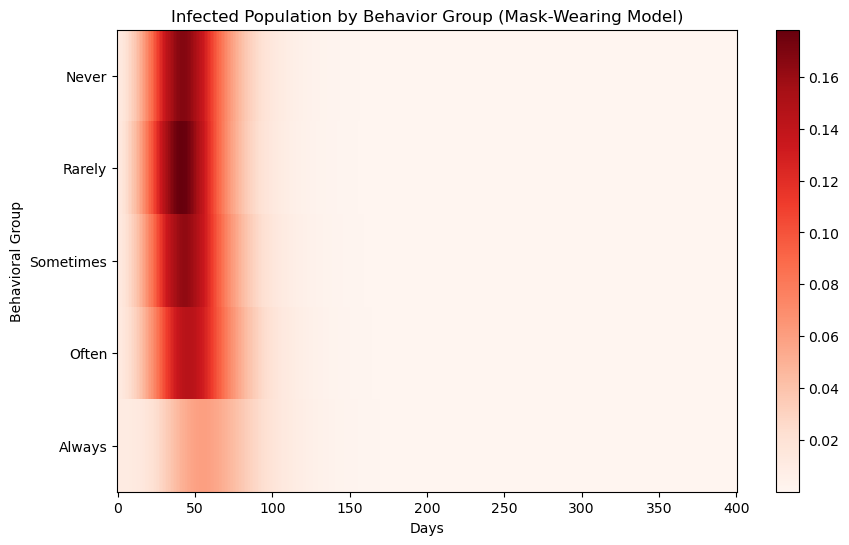

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow((I/DISTR_M).T, aspect='auto', cmap='Reds', interpolation='nearest')
ax.set_xlabel('Days')
ax.set_ylabel('Behavioral Group')
ax.set_title('Infected Population by Behavior Group (Mask-Wearing Model)')
ax.set_yticks(np.arange(5))
ax.set_yticklabels(['Never', 'Rarely', 'Sometimes', 'Often', 'Always'])
ax.grid(False)

# Add colorbar

plt.colorbar(ax.imshow((I/DISTR_M).T, aspect='auto', cmap='Reds', interpolation='nearest'))
plt.show()

1.8807992


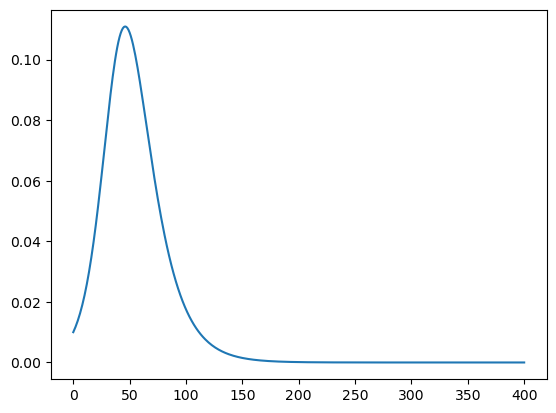

In [28]:
# calculate total number of infected individuals
total_infected = np.sum(I+R, axis=1)
total_infected
plt.plot(np.sum(I, axis=1))

print(r0)

In [ ]:
# run the SIRM_trajectory simulation

from src.models.consolidated_dynamics import sim_SIRV_final, sim_SIRT_final, sim_maskSIR_final


    
    behavior_distribution: Optional[jnp.ndarray] = None,
    custom_contact_matrix: Optional[jnp.ndarray] = None,
    custom_populations: Optional[jnp.ndarray] = None

(S, I, R), R0, _ = sim_maskSIR_trajectory(
    beta_params=(1.0, 1.0),
    params={
        'recovery_rate': 0.1,
        'dT': 0.25,
        'homophilic_tendency': 0,
        'beta_M': 0.6,
        'mu_max': 0.0
    },
    initial_infected_prop = 1e-4,
    n_steps=400,
    N_COMPARTMENTS = 100,
    behavior_distribution=DISTR_M,
    custom_contact_matrix=CM_M,
    custom_populations=np.array([0.2, 0.6, 0.2])
)

2

In [ ]:


demonstrate_r0_limitations('data_homophily.csv', 'mask')

TypeError: sim_maskSIR_final() got an unexpected keyword argument 'behavior_distribution'

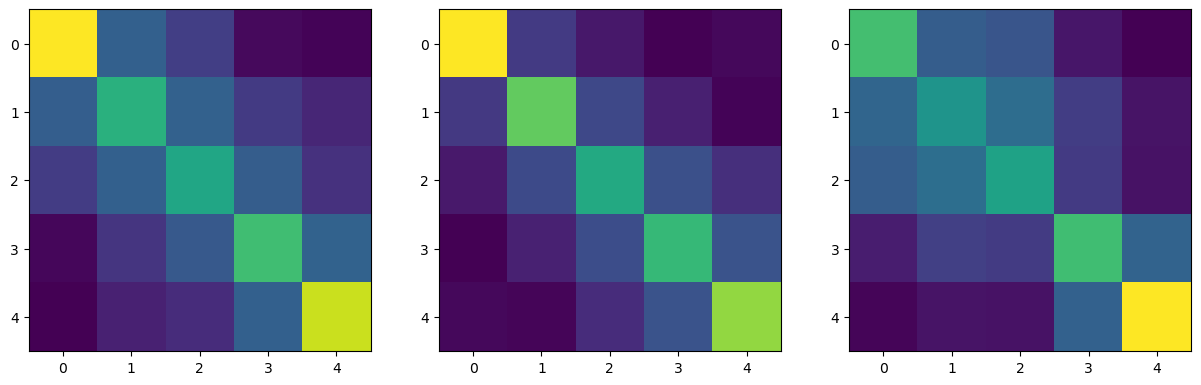

In [ ]:
import matplotlib.pyplot as plt



fig, axs = plt.subplots(1, 3, figsize=(15, 5))



axs[0].imshow(CM_M, cmap='viridis')



axs[1].imshow(CM_T, cmap='viridis')



axs[2].imshow(CM_V, cmap='viridis')


